## Index
```
Step 1. Import Libraries
Step 2. Design Layers
     2-a. linear layer
     2-b. convolution layer
     2-c. noise layer
     2-d. style modification layer
     2-e. pixel normalization layer
     2-f. blur layer
     2-g. upscaling layer

```
---

**1. Import Libraries****


In [17]:
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import Adam

np.random.seed(42)
tf.random.set_seed(42)

In [18]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Cài đặt kích thước ảnh và batch size
height, width = 224, 224
batch_size = 64

# 🔍 Tìm đúng đường dẫn dataset (tự động)
def find_dataset_path(base="/kaggle/input"):
    for dirname, _, filenames in os.walk(base):
        if "Covid19-dataset" in dirname:
            train_path = os.path.join(dirname, "train")
            test_path = os.path.join(dirname, "test")
            if os.path.exists(train_path) and os.path.exists(test_path):
                return train_path, test_path
    raise FileNotFoundError("Không tìm thấy folder chứa Covid19-dataset/train và test!")

TRAIN_VAL_DIR, TEST_DIR = find_dataset_path()

# ⚙️ Chuẩn bị dữ liệu
def generate_data(DIR, subset=None):
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2 if subset in ['training', 'validation'] else None
    )
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='categorical',
        target_size=(height, width),
        subset=subset
    )
    return generator

# 🚀 Tạo generators
train_generator = generate_data(TRAIN_VAL_DIR, subset='training')
validation_generator = generate_data(TRAIN_VAL_DIR, subset='validation')
test_generator = generate_data(TEST_DIR)

# 📊 Thống kê số lượng ảnh
total_image = np.concatenate([train_generator.labels, validation_generator.labels])
print('\\n\\n', {
    'Normal_cases': len(np.where(total_image == 0)[0]),
    'Viral_Pneumonia_cases': len(np.where(total_image == 1)[0]),
    'Covid_cases': len(np.where(total_image == 2)[0])
})


Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
\n\n {'Normal_cases': 111, 'Viral_Pneumonia_cases': 70, 'Covid_cases': 70}


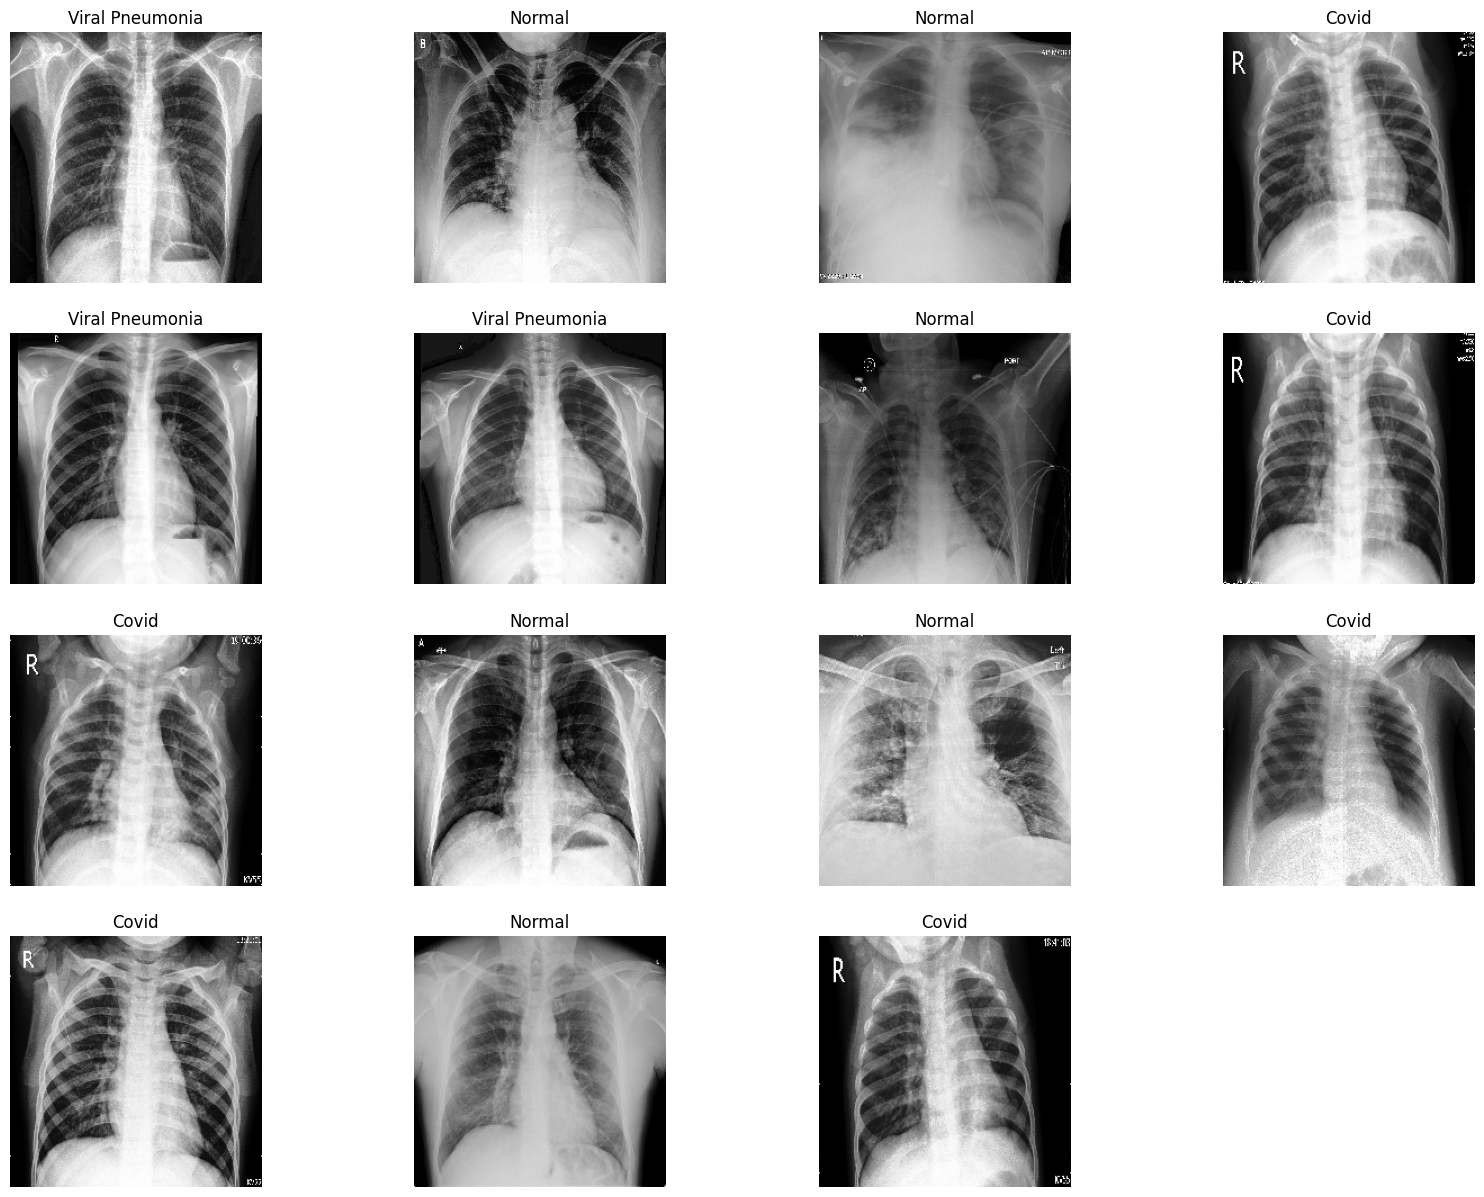

In [19]:
def image_plot(generator, image_numbers):
    # Lấy dữ liệu từ generator
    img_features, img_labels = next(generator)  # Lấy một batch dữ liệu từ generator

    # Giới hạn số lượng ảnh để plot
    img_features = img_features[:image_numbers]
    img_labels = img_labels[:image_numbers]

    # Chuyển đổi nhãn one-hot thành chỉ số lớp
    img_labels = np.argmax(img_labels, axis=1)

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers / 4), 4, i + 1)
        plt.imshow(img_features[i])
        plt.title("Normal" if img_labels[i] == 0 else "Viral Pneumonia" if img_labels[i] == 1 else "Covid")
        plt.axis("off")

    plt.show()

# Sử dụng hàm để plot ảnh từ train_generator
image_plot(train_generator, 15)

In [22]:

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

def get_model():
    input_tensor = Input(shape=(height, width, 3))
    
    # Backbone: dùng mô hình đã pretrained trên ImageNet
    base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    # Không train lại phần backbone
    base_model.trainable = False
    
    # Head mới cho task 3 lớp
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [23]:
model = get_model()

<ipython-input-22-56cc909dee14>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Epoch 1/70


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.3760 - loss: 1.7814 - val_accuracy: 0.5800 - val_loss: 0.9842
Epoch 2/70
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4688 - loss: 1.5477

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.4688 - loss: 1.5477 - val_accuracy: 0.6800 - val_loss: 0.7092
Epoch 3/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.6473 - loss: 0.7350 - val_accuracy: 0.8200 - val_loss: 0.4589
Epoch 4/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7344 - loss: 0.5816 - val_accuracy: 0.8000 - val_loss: 0.4547
Epoch 5/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.6827 - loss: 0.7148 - val_accuracy: 0.7800 - val_loss: 0.4324
Epoch 6/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6875 - loss: 0.5930 - val_accuracy: 0.8200 - val_loss: 0.4207
Epoch 7/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.8092 - loss: 0.4495 - val_accuracy: 0.8400 - val_loss: 0.3950
Epoch 8/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8594 - loss: 0.3695 - val_accuracy: 0.8400 - val_loss: 0.3963
Epoch 9/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.8640 - loss: 0.3384 - val_accuracy: 0.8400 - val_loss: 0.4162
Epoch 10/70
3/3 ━━━━━━━

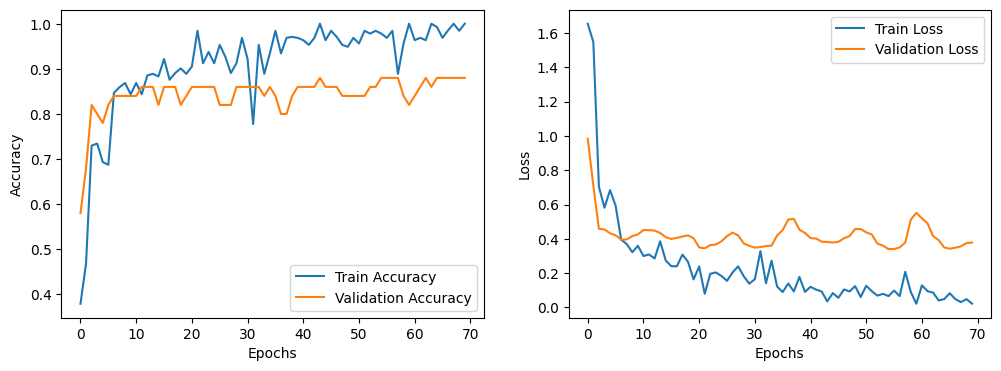

In [24]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=70,  # Số lượng epoch, có thể thay đổi để phù hợp với dữ liệu
    verbose=1
)

# Lưu mô hình sau khi huấn luyện
model.save('/kaggle/working/model_covid_classifier.h5')

# Đánh giá mô hình trên tập validation
_, acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size, verbose=0)
print(f'Model accuracy on validation data: {acc * 100.0:.3f}%')

# Vẽ biểu đồ accuracy và loss theo từng epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step  
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        26
         1.0       1.00      0.80      0.89        20
         2.0       0.83      1.00      0.91        20

    accuracy                           0.94        66
   macro avg       0.94      0.93      0.93        66
weighted avg       0.95      0.94      0.94        66



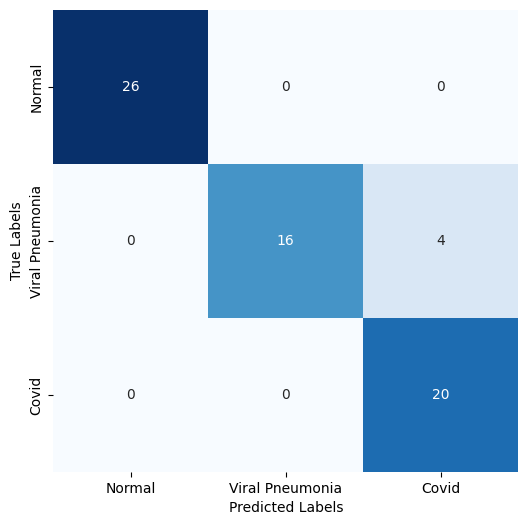

In [25]:
ytest = np.array([])
xtest = []

# Lặp qua các batch trong test_generator
for i in range(math.ceil(len(test_generator.classes) / batch_size)):
    xtest.append(test_generator[i][0])  # Lấy dữ liệu ảnh
    ytest = np.concatenate((ytest, np.argmax(test_generator[i][1], axis=1)))  # Chuyển nhãn từ dạng one-hot về dạng chỉ số lớp

# Nối các mảng lại với nhau
xtest = np.concatenate(xtest, axis=0)

# Dự đoán kết quả trên tập xtest
ypred_prob = model.predict(xtest)
ypred = np.argmax(ypred_prob, axis=1)

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest, ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
                 xticklabels=['Normal', 'Viral Pneumonia', 'Covid'],
                 yticklabels=['Normal', 'Viral Pneumonia', 'Covid'])  
hm.set(xlabel='Predicted Labels')
hm.set(ylabel='True Labels')

# In báo cáo phân loại
print(classification_report(ytest, ypred))


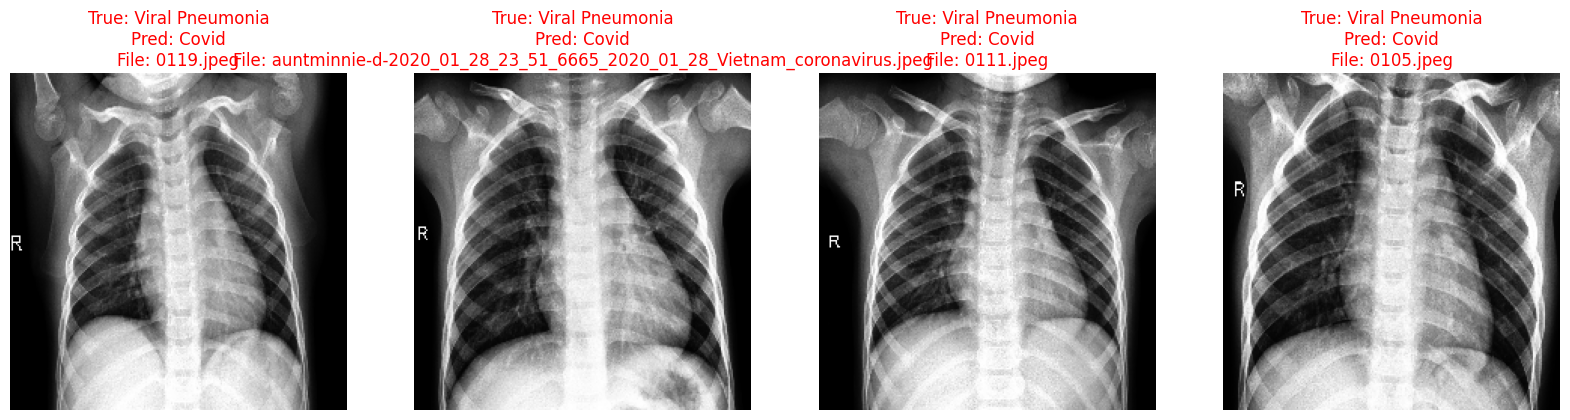

In [26]:
# Extract wrong classification index
wrong_pred = np.where(ypred != ytest)[0]

plt.figure(figsize=(20, 15))
for i, n in enumerate(wrong_pred):
    ax = plt.subplot(math.ceil(len(wrong_pred) / 4), 4, i + 1)
    plt.imshow(xtest[n])
    
    # Lấy nhãn thực tế và nhãn dự đoán
    true_label = "Normal" if ytest[n] == 0 else "Viral Pneumonia" if ytest[n] == 1 else "Covid"
    pred_label = "Normal" if ypred[n] == 0 else "Viral Pneumonia" if ypred[n] == 1 else "Covid"
    
    # Lấy tên file ảnh
    filename = test_generator.filenames[n].split('/')[-1]  # Lấy tên file từ đường dẫn
    
    # Hiển thị nhãn thực tế, nhãn dự đoán và tên file ảnh
    plt.title(f"True: {true_label}\nPred: {pred_label}\nFile: {filename}", color='red')
    plt.axis("off")

plt.show()


In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

# Cài đặt kích thước ảnh và batch size
height, width = 224, 224
batch_size = 64

# Tìm đúng đường dẫn chứa dữ liệu (tự động dò)
def find_dataset_path(base="/kaggle/input"):
    for dirname, _, filenames in os.walk(base):
        if "Covid19-dataset" in dirname:
            train_path = os.path.join(dirname, "train")
            test_path = os.path.join(dirname, "test")
            if os.path.exists(train_path) and os.path.exists(test_path):
                return train_path, test_path
    raise FileNotFoundError("Không tìm thấy folder chứa Covid19-dataset/train và test!")

TRAIN_VAL_DIR, TEST_DIR = find_dataset_path()

# ✅ Hàm load dữ liệu có Augmentation
def generate_data_augmented(DIR, subset=None):
    datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.1,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        validation_split=0.2 if subset in ['training', 'validation'] else None
    )
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='categorical',
        target_size=(height, width),
        subset=subset
    )
    return generator

# 🔄 Tạo generators
train_generator = generate_data_augmented(TRAIN_VAL_DIR, subset='training')
validation_generator = generate_data_augmented(TRAIN_VAL_DIR, subset='validation')
test_generator = generate_data_augmented(TEST_DIR)  # Không dùng subset cho test

# 📊 Thống kê số lượng ảnh
total_image = np.concatenate([train_generator.labels, validation_generator.labels])

print('\n\n', {
    'Normal_cases': len(np.where(total_image == 0)[0]),
    'Viral_Pneumonia_cases': len(np.where(total_image == 1)[0]),
    'Covid_cases': len(np.where(total_image == 2)[0])
})


Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


 {'Normal_cases': 111, 'Viral_Pneumonia_cases': 70, 'Covid_cases': 70}


Found 251 images belonging to 3 classes.


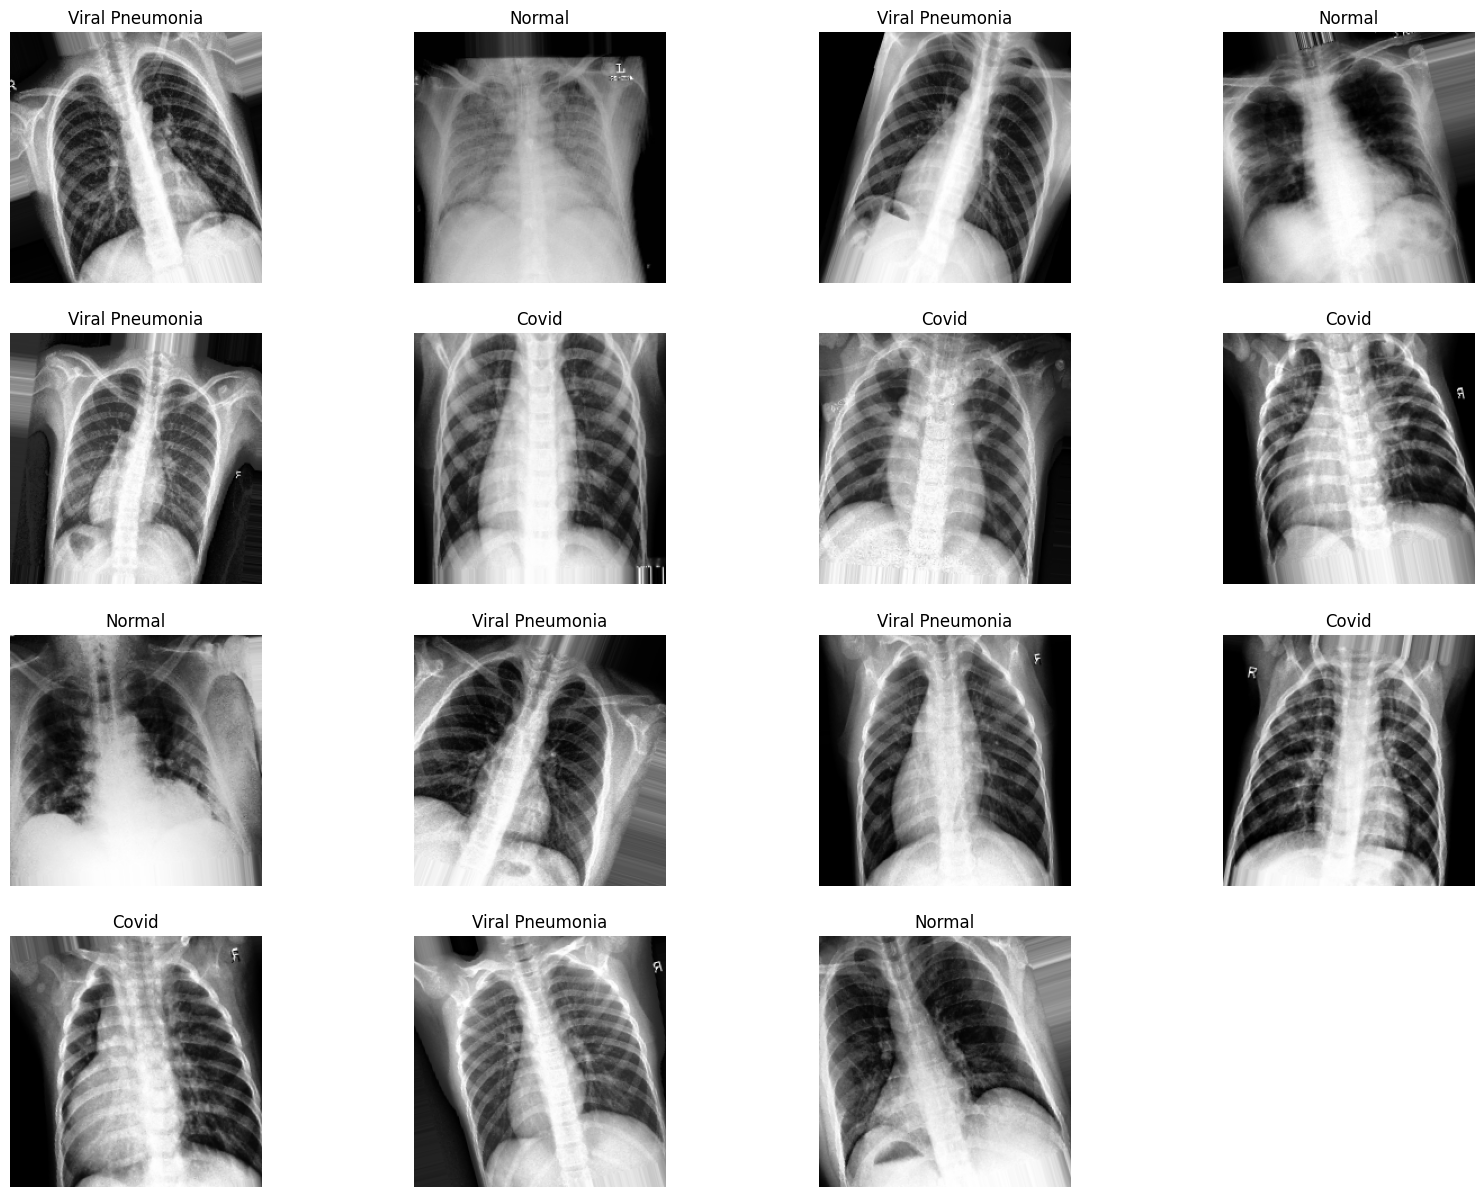

In [29]:
aug_train_generator = generate_data_augmented(TRAIN_VAL_DIR)

image_plot(aug_train_generator,15)


Epoch 1/70


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.8548 - loss: 0.4630 - val_accuracy: 0.8400 - val_loss: 0.4917
Epoch 2/70
1/3 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8750 - loss: 0.4369

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8750 - loss: 0.4369 - val_accuracy: 0.7200 - val_loss: 0.5667
Epoch 3/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.8182 - loss: 0.4958 - val_accuracy: 0.8000 - val_loss: 0.4568
Epoch 4/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8281 - loss: 0.5152 - val_accuracy: 0.8600 - val_loss: 0.4165
Epoch 5/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.8730 - loss: 0.3824 - val_accuracy: 0.8400 - val_loss: 0.3176
Epoch 6/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.8644 - loss: 0.3068 - val_accuracy: 0.8400 - val_loss: 0.3938
Epoch 7/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.8236 - loss: 0.3816 - val_accuracy: 0.8600 - val_loss: 0.3200
Epoch 8/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.8983 - loss: 0.2686 - val_accuracy: 0.9200 - val_loss: 0.2315
Epoch 9/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.8967 - loss: 0.2447 - val_accuracy: 0.9000 - val_loss: 0.2337
Epoch 10/70
3/3 ━━━━━━━

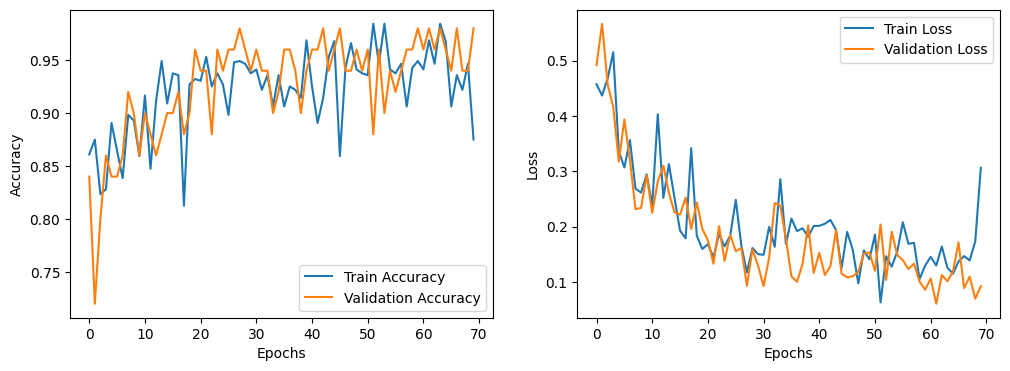

In [30]:
history = model.fit(
    aug_train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=70,  # Số lượng epoch, có thể thay đổi để phù hợp với dữ liệu
    verbose=1
)

# Lưu mô hình sau khi huấn luyện
model.save('/kaggle/working/model_covid_classifier.h5')

# Đánh giá mô hình trên tập validation
_, acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size, verbose=0)
print(f'Model accuracy on validation data: {acc * 100.0:.3f}%')

# Vẽ biểu đồ accuracy và loss theo từng epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 768ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99        89
         1.0       1.00      1.00      1.00        56
         2.0       0.98      1.00      0.99        56

    accuracy                           1.00       201
   macro avg       0.99      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201



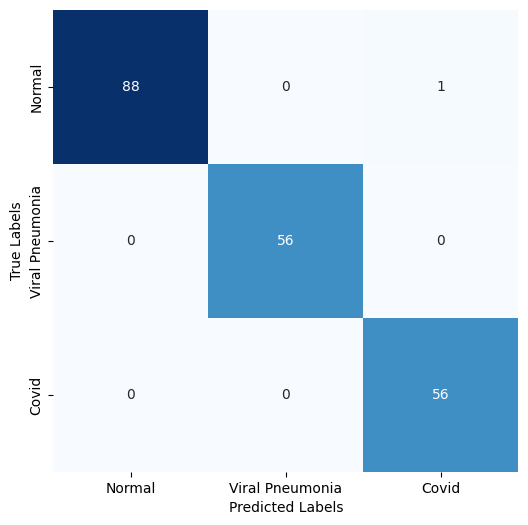

In [31]:
ytrain= np.array([])
xtrain = []

# Lặp qua các batch trong test_generator
for i in range(math.ceil(len(train_generator.classes) / batch_size)):
    xtrain.append(train_generator[i][0])  # Lấy dữ liệu ảnh
    ytrain = np.concatenate((ytrain, np.argmax(train_generator[i][1], axis=1)))  # Chuyển nhãn từ dạng one-hot về dạng chỉ số lớp

# Nối các mảng lại với nhau
xtrain = np.concatenate(xtrain, axis=0)

# Dự đoán kết quả trên tập xtest
ypred_prob = model.predict(xtrain)
ypred = np.argmax(ypred_prob, axis=1)

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytrain, ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
                 xticklabels=['Normal', 'Viral Pneumonia', 'Covid'],
                 yticklabels=['Normal', 'Viral Pneumonia', 'Covid'])  
hm.set(xlabel='Predicted Labels')
hm.set(ylabel='True Labels')

# In báo cáo phân loại
print(classification_report(ytrain, ypred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 429ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98        26
         1.0       1.00      0.65      0.79        20
         2.0       0.71      1.00      0.83        20

    accuracy                           0.88        66
   macro avg       0.90      0.87      0.87        66
weighted avg       0.91      0.88      0.88        66



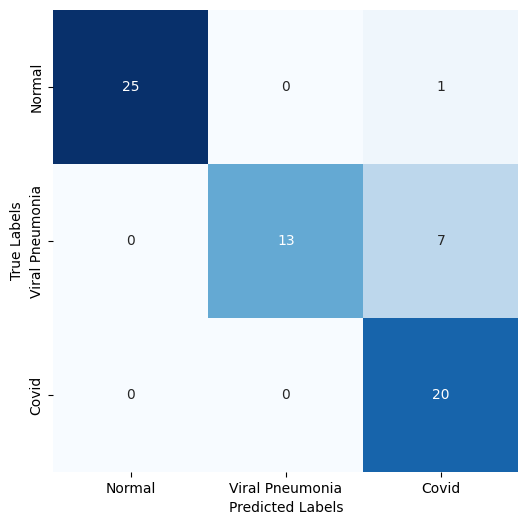

In [32]:
ytest = np.array([])
xtest = []

# Lặp qua các batch trong test_generator
for i in range(math.ceil(len(test_generator.classes) / batch_size)):
    xtest.append(test_generator[i][0])  # Lấy dữ liệu ảnh
    ytest = np.concatenate((ytest, np.argmax(test_generator[i][1], axis=1)))  # Chuyển nhãn từ dạng one-hot về dạng chỉ số lớp

# Nối các mảng lại với nhau
xtest = np.concatenate(xtest, axis=0)

# Dự đoán kết quả trên tập xtest
ypred_prob = model.predict(xtest)
ypred = np.argmax(ypred_prob, axis=1)

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest, ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
                 xticklabels=['Normal', 'Viral Pneumonia', 'Covid'],
                 yticklabels=['Normal', 'Viral Pneumonia', 'Covid'])  
hm.set(xlabel='Predicted Labels')
hm.set(ylabel='True Labels')

# In báo cáo phân loại
print(classification_report(ytest, ypred))

In [33]:
import os

if os.path.exists("/kaggle/working/model_covid_classifier.h5"):
    print("✅ File đã được lưu!")
else:
    print("❌ File chưa được tạo.")

✅ File đã được lưu!
